## Prediction Problem 

+ Predict the probability that somebody will experience financial distress in the next two years.
+ Goal - Use the outputted value by the model and convert it to a FICO style score.

In [1]:
# 导入所需包
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [2]:
data = pd.read_csv('data/cs-training.csv')
data.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data = pd.read_csv('data/cs-training.csv').drop('Unnamed: 0', axis = 1)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## 数据说明

||变量名 | 变量类型 | 变量描述|
| ---- |---- | ---- | ----|
| Res |SeriousDlqin2yrs | Y/N | 超过90天或更糟的逾期拖欠|
|F1|RevolvingUtilizationOf UnsecuredLines | percentage | 无担保放款的循环利用：除了不动产和像车贷那样除以信用额度总和的无分期付款债务的信用卡和个人信用额度总额|
|F2|age | integer  | 借款人当时的年龄|
|F3|NumberOfTime30-59DaysPastDueNotWorse | integer | 35-59天逾期但不糟糕次数|
|F4|DebtRatio | percentage | 负债比率|
|F5|MonthlyIncome | real | 月收入|
|F6|NumberOf OpenCreditLinesAndLoans | integer|开放式信贷和贷款数量，开放式贷款（分期付款如汽车贷款或抵押贷款）和信贷（如信用卡）的数量|
|F7|NumberOfTimes90DaysLate | integer |90天逾期次数：借款者有90天或更高逾期的次数|
|F8|NumberRealEstateLoans OrLines | integer | 不动产贷款或额度数量：抵押贷款和不动产放款包括房屋净值信贷额度|
|F9|NumberOfTime60-89DaysPastDueNotWorse | integer | 60-89天逾期但不糟糕次数：借款人在在过去两年内有60-89天逾期还款但不糟糕的次数|
|F10|NumberOfDependents | integer | 家属数量：不包括本人在内的家属数量|

In [4]:
# 标签替换
cleanCol = []
for i in range(len(data.columns)):
    cleanCol.append(data.columns[i].replace('-', ''))
    
data.columns = cleanCol
data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime3059DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime6089DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

### 数据清洗


In [5]:
## 定义工具类函数

# 中位数填充
def  removeSpecificAndPutMedianremoveSpe (data, first = 98, second = 96):
    New = []
    med = data.median()
    for val in data:
        if ((val == first) | (val == second)):
            New.append(med)
        else:
            New.append(val)
            
    return New

def add_freq():
    ncount = len(data)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)

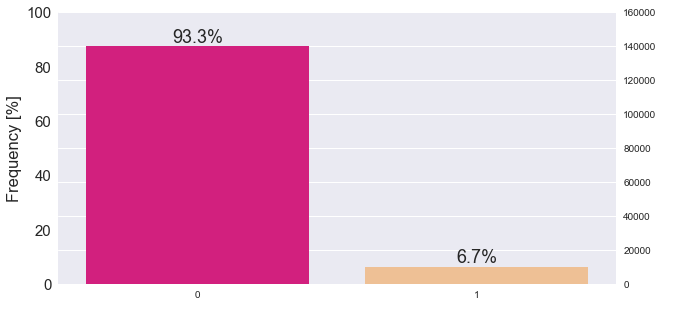

In [6]:
# 数据平衡
ax = sns.countplot(x = data.SeriousDlqin2yrs ,palette="Accent_r")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

add_freq()

plt.show()

In [7]:
# 异常值检测

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    (minval, maxval) = np.percentile(data, [diff, 100 - diff])
    return ((data < minval) | (data > maxval))

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if val/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(data.index, x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutlier(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in list(zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote])):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = x[func(x)]
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)
    
def plotOutlierFree(x):
    fig, axes = plt.subplots(nrows=4)
    nOutliers = []
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        tfOutlier = list(zip(x, func(x)))
        nOutliers.append(len([index for (index, bol) in tfOutlier if bol == True]))
        outlierFree = [index for (index, bol) in tfOutlier if bol == True]
        sns.distplot(outlierFree, ax=ax, rug=True, hist=False)
        
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=15)
    axes[0].set_title('Percentile-based Outliers, removed: {r}'.format(r=nOutliers[0]), **kwargs)
    axes[1].set_title('MAD-based Outliers, removed: {r}'.format(r=nOutliers[1]), **kwargs)
    axes[2].set_title('STD-based Outliers, removed: {r}'.format(r=nOutliers[2]), **kwargs)
    axes[3].set_title('Majority vote based Outliers, removed: {r}'.format(r=nOutliers[3]), **kwargs)
    fig.suptitle('Outlier Removed By Method with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(15,10)

    
def outlierRatio(data):
    functions = [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]
    outlierDict = {}
    for func in functions:
        funcResult = func(data)
        count = 0
        for val in funcResult:
            if val == True:
                count += 1 
        outlierDict[str(func)[10:].split()[0]] = [count, '{:.2f}%'.format((float(count)/len(data))*100)]
    
    return outlierDict

def replaceOutlier(data, method = outlierVote, replace='median'):
    '''replace: median (auto)
                'minUpper' which is the upper bound of the outlier detection'''
    vote = outlierVote(data)
    x = pd.DataFrame(zip(data, vote), columns=['debt', 'outlier'])
    if replace == 'median':
        replace = x.debt.median()
    elif replace == 'minUpper':
        replace = min([val for (val, vote) in zip(data, vote) if vote == True])
        if replace < data.mean():
            return 'There are outliers lower than the sample mean'
    debtNew = []
    for i in range(x.shape[0]):
        if x.iloc[i][1] == True:
            debtNew.append(replace)
        else:
            debtNew.append(x.iloc[i][0])
    
    return debtNew


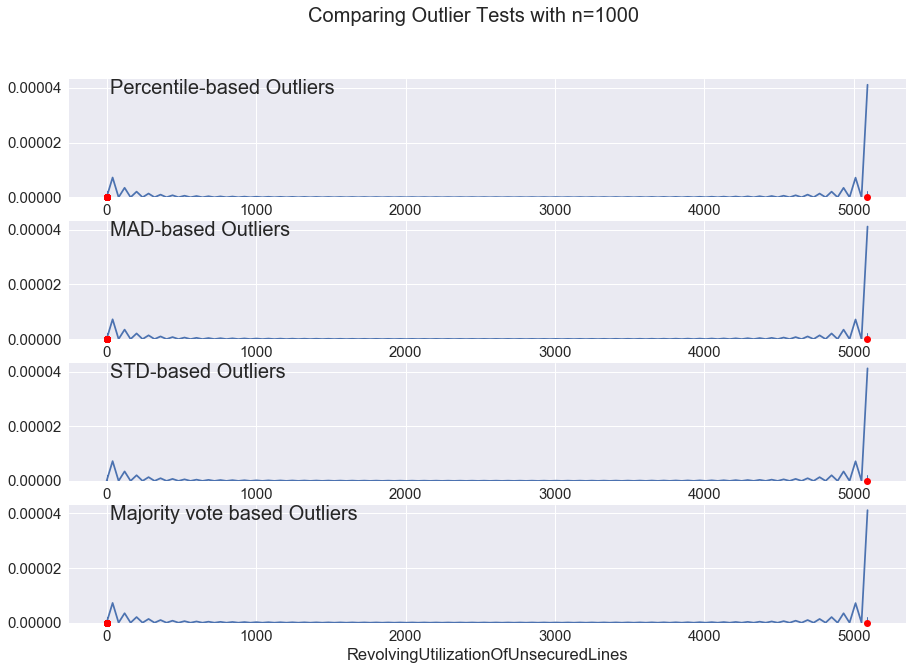

In [8]:
# RevolvingUtilizationOfUnsecuredLines var
plotOutlier(data.RevolvingUtilizationOfUnsecuredLines.sample(1000))

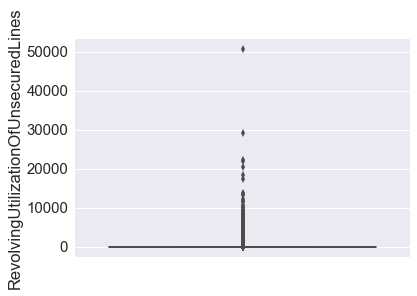

In [9]:
sns.boxplot(y=data.RevolvingUtilizationOfUnsecuredLines)
# data.RevolvingUtilizationOfUnsecuredLines.plot.box()

In [10]:
def detectoutliers(list):  
    print(type(list))  
    outlier_indices = []  
    # iterate over features(columns)  
  
        # 1st quartile (25%)  
    Q1 = np.percentile(list, 25)  
    # 3rd quartile (75%)  
    Q3 = np.percentile(list,75)  
    # Interquartile range (IQR)  
    IQR = Q3 - Q1  
    # outlier step  
    outlier_step = 1.5 * IQR  
    # Determine a list of indices of outliers for feature col  
    outlier_list_col = list[(list < Q1 - outlier_step) | (list > Q3 + outlier_step )]  
  
    return outlier_list_col  

In [11]:
len(detectoutliers(data.RevolvingUtilizationOfUnsecuredLines))/len(data)

<class 'pandas.core.series.Series'>


0.005086666666666666

In [12]:
# 对大于2的数进行替换处理
revNew = []
for val in data.RevolvingUtilizationOfUnsecuredLines:
    if val <= 2:
        revNew.append(val)
    else:
        revNew.append(2.)

In [13]:
data.RevolvingUtilizationOfUnsecuredLines = revNew

###  Age var

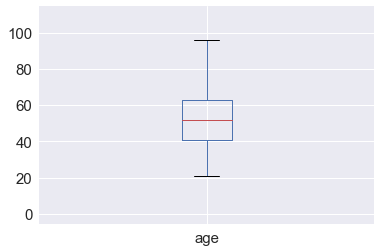

In [14]:
data.age.plot.box()

In [15]:
# 对小于22岁用22替换
ageNew = []
for val in data.age:
    if val > 22:
        ageNew.append(val)
    else:
        ageNew.append(22)
        
data.age = ageNew

In [16]:
# NumberOfTime3059DaysPastDueNotWorse var¶
from collections import Counter
Counter(data.NumberOfTime3059DaysPastDueNotWorse)

Counter({2: 4598,
         0: 126018,
         1: 16033,
         3: 1754,
         4: 747,
         5: 342,
         7: 54,
         10: 4,
         6: 140,
         98: 264,
         12: 2,
         8: 25,
         9: 12,
         96: 5,
         13: 1,
         11: 1})

In [17]:
New = []
med = data.NumberOfTime3059DaysPastDueNotWorse.median()
for val in data.NumberOfTime3059DaysPastDueNotWorse:
    if ((val == 98) | (val == 96)):
        New.append(med)
    else:
        New.append(val)

data.NumberOfTime3059DaysPastDueNotWorse = New

In [18]:
# DebtRatio var
outlierRatio(data.DebtRatio)

{'percentile_based_outlier': [3750, '2.50%'],
 'mad_based_outlier': [31727, '21.15%'],
 'std_div': [779, '0.52%'],
 'outlierVote': [3750, '2.50%']}

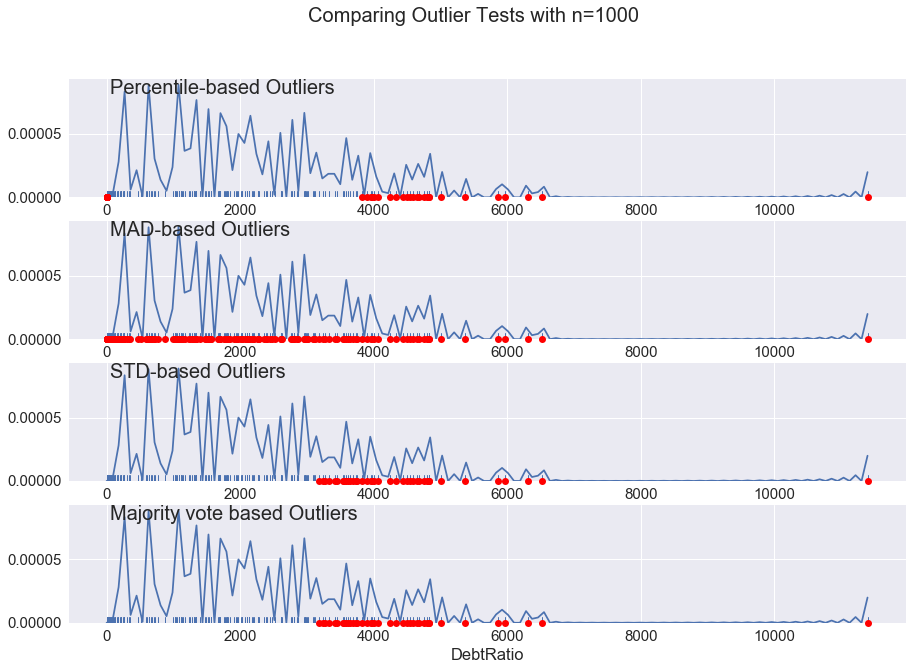

In [19]:
plotOutlier(data.DebtRatio.sample(1000))

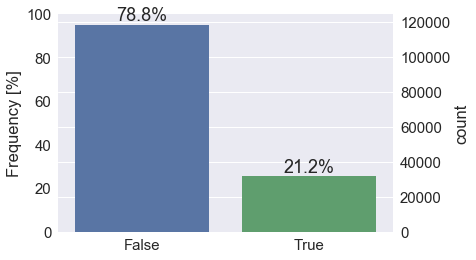

In [20]:
ax = sns.countplot(mad_based_outlier(data.DebtRatio))
add_freq()

In [21]:
minUpperBound = min([val for (val, out) in zip(data.DebtRatio, mad_based_outlier(data.DebtRatio)) if out == True])

In [22]:
newDebtRatio = []
for val in data.DebtRatio:
    if val > minUpperBound:
        newDebtRatio.append(minUpperBound)
    else:
        newDebtRatio.append(val)

In [23]:
data.DebtRatio = newDebtRatio
data.DebtRatio.describe()

count    150000.000000
mean          0.607359
std           0.588294
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max           1.641791
Name: DebtRatio, dtype: float64

In [24]:
#knn 填充 
from sklearn.neighbors import KNeighborsRegressor

income_imputer = KNeighborsRegressor(n_neighbors=3)

In [25]:
data[data.MonthlyIncome.isnull() == False].corr().iloc[:,5]

SeriousDlqin2yrs                       -0.019746
RevolvingUtilizationOfUnsecuredLines   -0.034696
age                                     0.037695
NumberOfTime3059DaysPastDueNotWorse    -0.001786
DebtRatio                              -0.093711
MonthlyIncome                           1.000000
NumberOfOpenCreditLinesAndLoans         0.091455
NumberOfTimes90DaysLate                -0.012743
NumberRealEstateLoansOrLines            0.124959
NumberOfTime6089DaysPastDueNotWorse    -0.011116
NumberOfDependents                      0.062647
Name: MonthlyIncome, dtype: float64

In [26]:
# 使用NumberRealEstateLoansOrLines、NumberOfOpenCreditLinesAndLoans变量预测MonthlyIncome
cols = ['NumberRealEstateLoansOrLines', 'NumberOfOpenCreditLinesAndLoans']

trainMonthlyIncome = data[data.MonthlyIncome.isnull() == False]
trainNaNMonthlyIncome = data[data.MonthlyIncome.isnull() == True]

income_imputer.fit(trainMonthlyIncome[cols], trainMonthlyIncome.MonthlyIncome)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [27]:
new_values = income_imputer.predict(trainNaNMonthlyIncome[cols])
trainNaNMonthlyIncome.loc[:, 'MonthlyIncome'] = new_values
new_values


d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


array([ 8450.        ,  4611.        , 14889.        , ...,
        5810.33333333,  9800.33333333,  7492.33333333])

In [28]:
# combine the data back together
data = trainMonthlyIncome.append(trainNaNMonthlyIncome)
data.isnull().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime3059DaysPastDueNotWorse        0
DebtRatio                                  0
MonthlyIncome                              0
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime6089DaysPastDueNotWorse        0
NumberOfDependents                      3924
dtype: int64

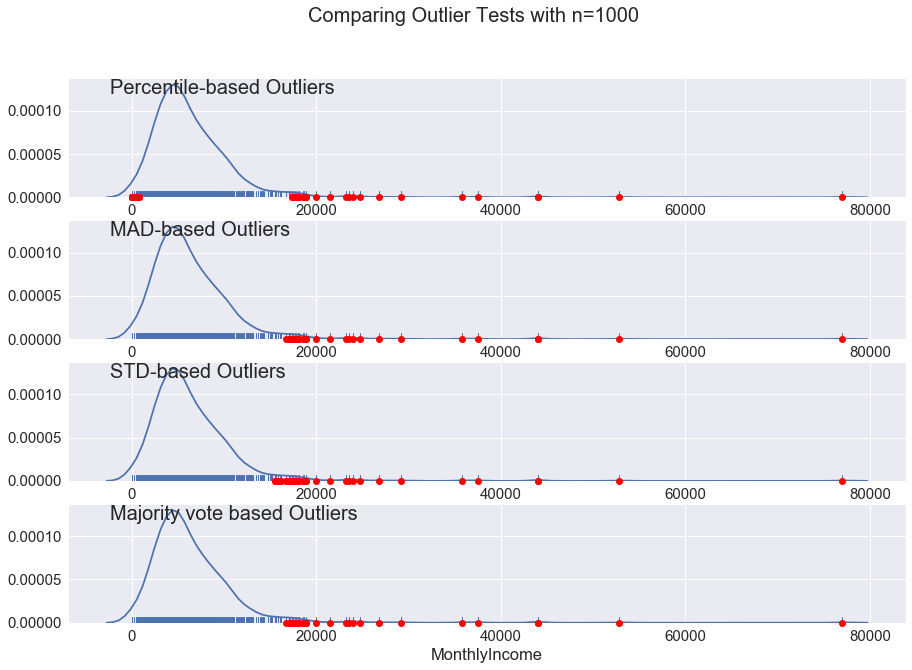

In [29]:
plotOutlier(data.MonthlyIncome.sample(1000))

In [30]:
data.MonthlyIncome.max()

3008750.0

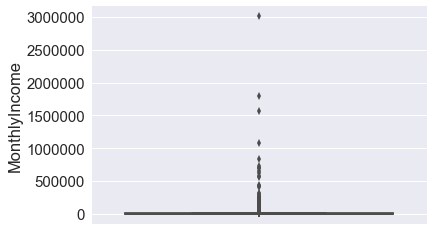

In [31]:
sns.boxplot(y=data.MonthlyIncome)

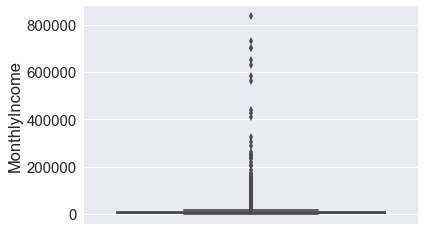

In [32]:
data = data[data['MonthlyIncome'] < 1000000]
sns.boxplot(y=data.MonthlyIncome)

In [33]:
# detectoutliers(data.MonthlyIncome).median()

In [34]:
# NumberOfTimes90DaysLate var
new = removeSpecificAndPutMedianremoveSpe(data.NumberOfTimes90DaysLate)
data.NumberOfTimes90DaysLate = new

In [35]:
# NumberRealEstateLoansOrLines var
realNew = []
for val in data.NumberRealEstateLoansOrLines:
    if val > 17:
        realNew.append(17)
    else:
        realNew.append(val)
        
data.NumberRealEstateLoansOrLines = realNew

In [36]:
# NumberOfTime6089DaysPastDueNotWorse var
new = removeSpecificAndPutMedianremoveSpe(data.NumberOfTime6089DaysPastDueNotWorse)
data.NumberOfTime6089DaysPastDueNotWorse = new

In [37]:
depNew = []

med = data.NumberOfDependents.median()
for val in data.NumberOfDependents:
    if val.is_integer() == False:
        depNew.append(med)
    else:
        depNew.append(val)
data.NumberOfDependents = depNew

In [38]:
data.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime3059DaysPastDueNotWorse     0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime6089DaysPastDueNotWorse     0
NumberOfDependents                      0
dtype: int64

## Train-Test split

In [39]:
from sklearn.model_selection import train_test_split

X = data.drop('SeriousDlqin2yrs', axis=1)
y = data.SeriousDlqin2yrs

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [41]:
### PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sScaler = StandardScaler(copy=True, with_mean=True, with_std=True)

xScaled = sScaler.fit_transform(X_train)

forPca = pd.DataFrame(xScaled)

pcaMod = PCA(n_components=2)

xPca = pcaMod.fit_transform(X)

xPcaDataframe = pd.DataFrame(xPca, columns=['PC1', 'PC2'])

xPcaDataframe['cat'] = y

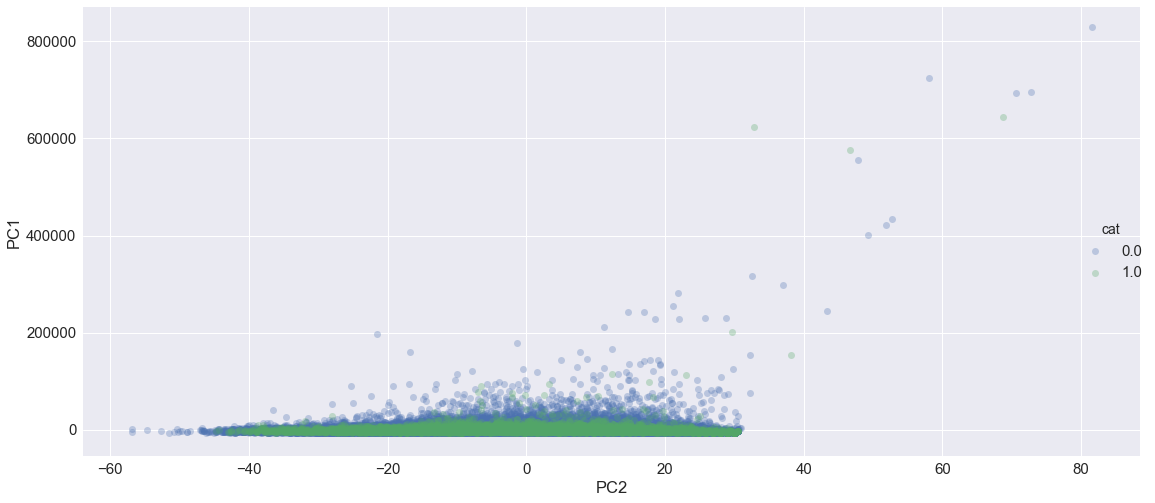

In [42]:
ax = sns.lmplot(data = xPcaDataframe, x='PC2', y='PC1', hue='cat', size=10, aspect=20, fit_reg=False,
               scatter_kws={'alpha': 0.3})
fig = plt.gcf()
fig.set_size_inches(15, 7)

In [43]:
## t-SNE


from sklearn.manifold import TSNE
import random

tsneMod = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, learning_rate=50., n_iter=500,
               metric='euclidean', init='random', verbose=2, random_state=None)

n = 7000
X_data, X_none, y_data, y_none = train_test_split(X, y, test_size=(1-(n/float(len(data)))))

xTsne = tsneMod.fit_transform(X_data)
xTsneDataFrame = pd.DataFrame(xTsne, columns=['one', 'two'])

y_data.index = range(0,len(xTsneDataFrame))

xTsneDataFrame['cat'] = y_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.009s...
[t-SNE] Computed neighbors for 7000 samples in 0.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 10.049575
[t-SNE] Computed conditional probabilities in 0.550s
[t-SNE] Iteration 50: error = 26.8974838, gradient norm = 0.0069263 (50 iterations in 17.560s)
[t-SNE] Iteration 100: error = 16.9328785, gradient norm = 0.0031327 (50 iterations in 10.488s)
[t-SNE] Iteration 150: error = 14.2018003, gradient norm = 0.0019486 (50 iterations in 10.350s)
[t-SNE] Iteration 200: erro

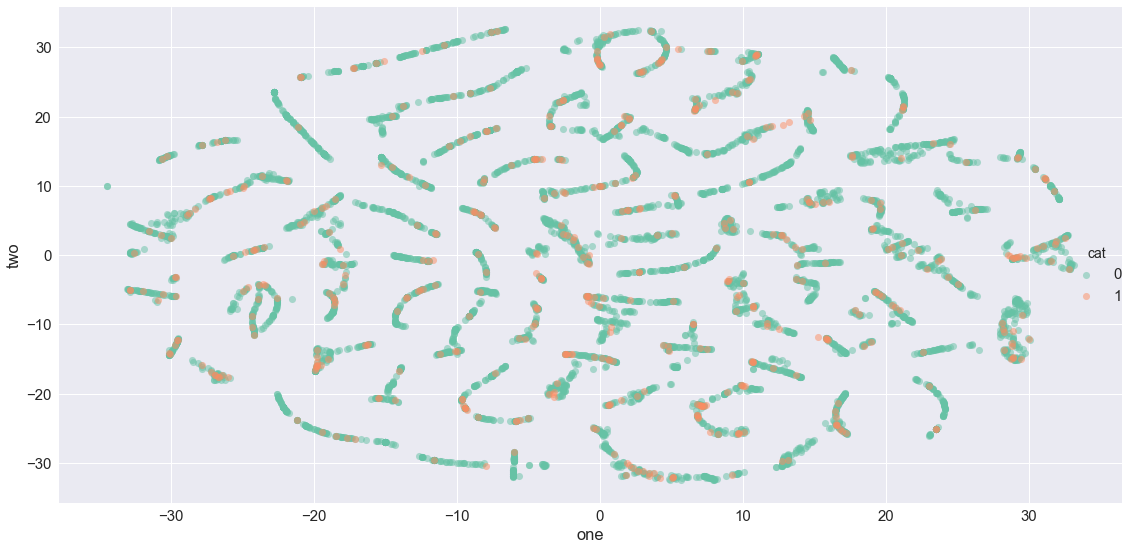

In [44]:
ax = sns.lmplot(data = xTsneDataFrame, x='one', y='two', hue='cat', size=70, aspect=5, fit_reg=False, palette='Set2',
               scatter_kws={"s": 50, 'alpha': 0.5})
fig = plt.gcf()
fig.set_size_inches(15, 7)

In [45]:
# Making predictions 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [46]:
knMod = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2,
                             metric='minkowski', metric_params=None)

In [47]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [48]:
adaMod = AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=1.0)

In [49]:
gbMod = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, subsample=1.0,
                                   min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                   init=None, random_state=None, max_features=None, verbose=0)

In [50]:
rfMod = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2,
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto',
                               max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0)

In [51]:
def cvDictGen(functions, scr, X_train=X_train, y_train=y_train, cv=3, verbose=1):
    cvDict = {}
    for func in functions:
        cvScore = cross_val_score(func, X_train, y_train, cv=cv, verbose=verbose, scoring=scr)
        cvDict[str(func).split('(')[0]] = [cvScore.mean(), cvScore.std()]
    
    return cvDict

def cvDictNormalize(cvDict):
    cvDictNormalized = {}
    for key in cvDict.keys():
        for i in cvDict[key]:
            cvDictNormalized[key] = ['{:0.2f}'.format((cvDict[key][0]/cvDict[list(cvDict.keys())[0]][0])),
                                     '{:0.2f}'.format((cvDict[key][1]/cvDict[list(cvDict.keys())[0]][1]))]
    return cvDictNormalized

In [52]:
cvD = cvDictGen(functions=[knMod, glmMod, adaMod, gbMod, rfMod], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s finished


[LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.7s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   41.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


In [53]:
cvDictNormalize(cvD)

{'KNeighborsClassifier': ['1.00', '1.00'],
 'LogisticRegression': ['1.47', '1.48'],
 'AdaBoostClassifier': ['1.49', '2.42'],
 'GradientBoostingClassifier': ['1.50', '1.34'],
 'RandomForestClassifier': ['1.35', '1.14']}

In [54]:
# Hyper parameter optimization

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [55]:
adaHyperParams = {'n_estimators': [10,50,100,200,400]}

In [56]:
gridSearchAda = RandomizedSearchCV(estimator=adaMod, param_distributions=adaHyperParams, n_iter=5,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.6s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .................................. n_estimators=10, total=   0.7s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   0.6s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   3.1s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   3.2s
[CV] n_estimators=50 .................................................
[CV] .................................. n_estimators=50, total=   3.1s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   6.2s
[CV] n_estimators=100 ................................................
[CV] ................................. n_estimators=100, total=   6.1s
[CV] n_estimators=100 ................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.0min finished


In [57]:
gridSearchAda.best_params_, gridSearchAda.best_score_

({'n_estimators': 100}, 0.857095052122676)

In [58]:
gbHyperParams = {'loss' : ['deviance', 'exponential'],
                 'n_estimators': randint(10, 500),
                 'max_depth': randint(1,10)}

In [59]:
gridSearchGB = RandomizedSearchCV(estimator=gbMod, param_distributions=gbHyperParams, n_iter=10,
                                   scoring='roc_auc', fit_params=None, cv=None, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] loss=exponential, max_depth=1, n_estimators=178 .................
[CV] .. loss=exponential, max_depth=1, n_estimators=178, total=   4.0s
[CV] loss=exponential, max_depth=1, n_estimators=178 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] .. loss=exponential, max_depth=1, n_estimators=178, total=   4.2s
[CV] loss=exponential, max_depth=1, n_estimators=178 .................
[CV] .. loss=exponential, max_depth=1, n_estimators=178, total=   4.0s
[CV] loss=exponential, max_depth=5, n_estimators=103 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=103, total=  13.7s
[CV] loss=exponential, max_depth=5, n_estimators=103 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=103, total=  15.1s
[CV] loss=exponential, max_depth=5, n_estimators=103 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=103, total=  13.8s
[CV] loss=exponential, max_depth=5, n_estimators=271 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=271, total=  37.4s
[CV] loss=exponential, max_depth=5, n_estimators=271 .................
[CV] .. loss=exponential, max_depth=5, n_estimators=271, total=  38.8s
[CV] loss=exponential, max_depth=5, n_estimators=271 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 21.2min finished


In [60]:
gridSearchGB.best_params_, gridSearchGB.best_score_

({'loss': 'exponential', 'max_depth': 5, 'n_estimators': 103},
 0.8624117260986935)

In [61]:
bestGbModFitted = gridSearchGB.best_estimator_.fit(X_train, y_train)

In [62]:
bestAdaModFitted = gridSearchAda.best_estimator_.fit(X_train, y_train)

In [63]:
cvDictHPO = cvDictGen(functions=[bestGbModFitted, bestAdaModFitted], scr='roc_auc')

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   39.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   18.6s finished


In [64]:
# Plot ROC curve with CV¶
# plotCvRocCurve will plot the CV ROC curve with nfolds
# rocZeroOne will compute the best cut-off point for the classifiers
def plotCvRocCurve(X, y, classifier, nfolds=5):
    
    from sklearn.metrics import roc_curve, auc
    from sklearn.cross_validation import StratifiedKFold
    import matplotlib.pyplot as plt
    from scipy import interp

    cv = StratifiedKFold(y, n_folds=nfolds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CV ROC curve')
    plt.legend(loc="lower right")
    fig = plt.gcf()
    fig.set_size_inches(15,5)

    plt.show()

def rocZeroOne(y_true, y_predicted_porba):
    
    from sklearn.metrics import roc_curve
    from scipy.spatial.distance import euclidean
    
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted_porba[:, 1])
    
    best = [0, 1]
    dist = []
    for (x, y) in zip(fpr, tpr):
        dist.append([euclidean([x,y], best)])

    bestPoint = [fpr[dist.index(min(dist))], tpr[dist.index(min(dist))]]
    
    bestCutOff1 = thresholds[list(fpr).index(bestPoint[0])]
    bestCutOff2 = thresholds[list(tpr).index(bestPoint[1])]
    
    print ('\n' + 'Best point on the ROC: TPR = {:0.3f}%, FPR = {:0.3f}%'.format(bestPoint[1]*100, bestPoint[0]*100))
    print ('\n' + 'Best Cut-Off point: {:0.4f}'.format(bestCutOff1))

    plt.plot(dist)
    plt.xlabel('Index')
    plt.ylabel('Euclidean Distance to the perfect [0,1]')
    fig = plt.gcf()
    fig.set_size_inches(15,5)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


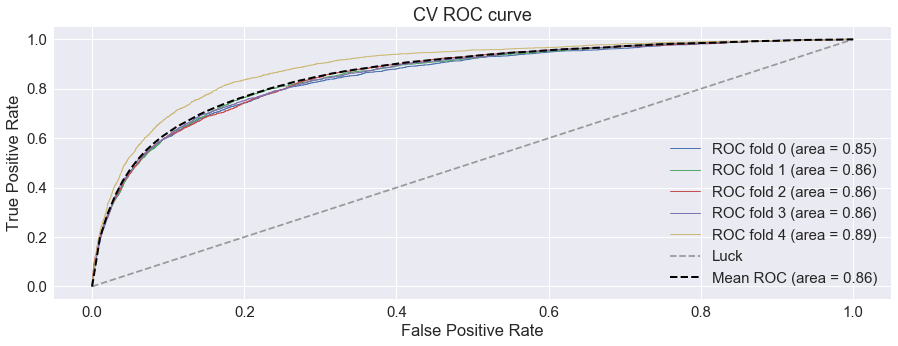

In [65]:
plotCvRocCurve(X, y, gridSearchGB.best_estimator_)


Best point on the ROC: TPR = 80.047%, FPR = 20.407%

Best Cut-Off point: 0.0642


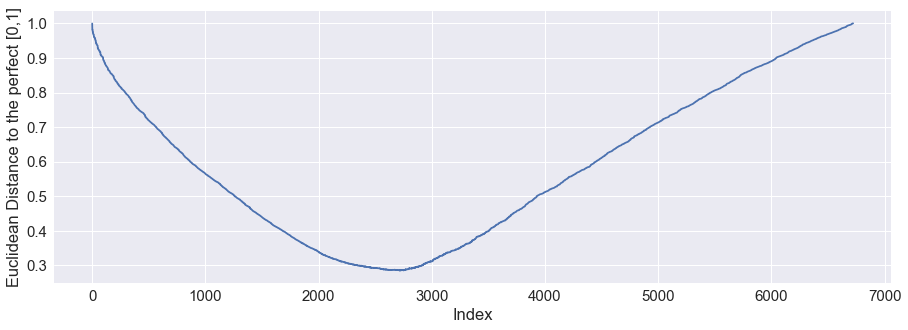

In [66]:
rocZeroOne(y_test, bestGbModFitted.predict_proba(X_test))

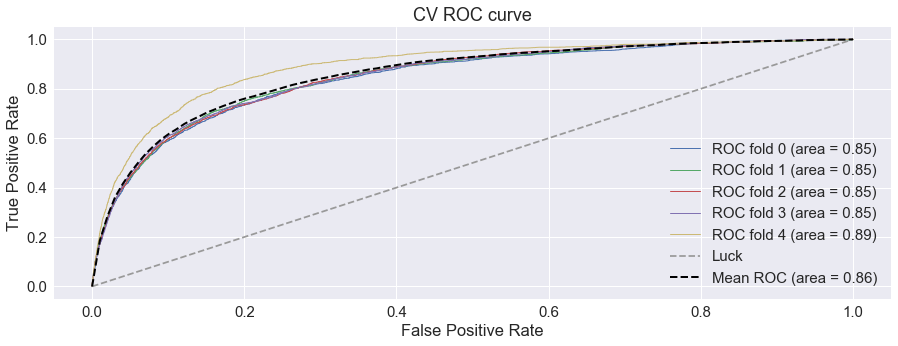

In [67]:
plotCvRocCurve(X, y, gridSearchAda.best_estimator_)


Best point on the ROC: TPR = 78.273%, FPR = 21.022%

Best Cut-Off point: 0.4932


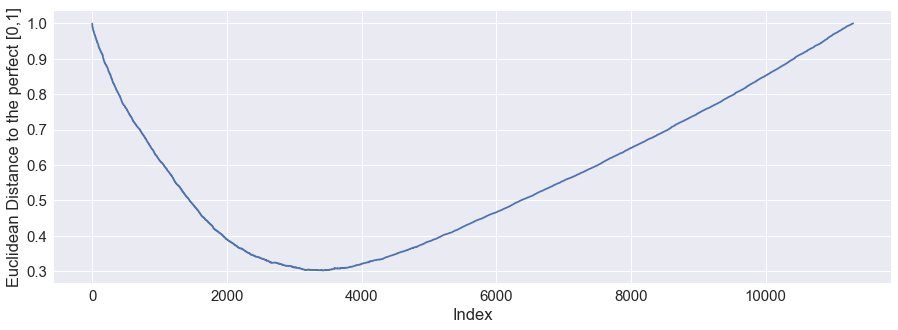

In [68]:
rocZeroOne(y_test, bestAdaModFitted.predict_proba(X_test))

In [69]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion matrix', cmap=plt.cm.Blues):
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
    print ('Classification Report:\n')
    print (classification_report(y_test, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    def plot_confusion_matrix_plot(cm, title = 'Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(y_test.unique()))
        plt.xticks(tick_marks, rotation=45)
        plt.yticks(tick_marks)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    print ('\n Confusion matrix, without normalization: \n')
    print (cm)
    plot_confusion_matrix_plot(cm=cm)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('\n Normalized confusion matrix \n')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix_plot(cm_normalized, title='Normalized confusion matrix')
    
def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

In [70]:
pred = makePredThresh(bestGbModFitted, thr=0.0645)

Classification Report:

             precision    recall  f1-score   support

          0       0.98      0.80      0.88     34963
          1       0.22      0.80      0.35      2536

avg / total       0.93      0.80      0.84     37499


 Confusion matrix, without normalization: 

[[27862  7101]
 [  511  2025]]

 Normalized confusion matrix 

[[0.79689958 0.20310042]
 [0.20149842 0.79850158]]


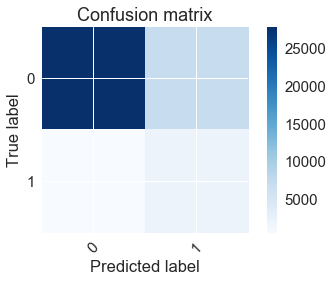

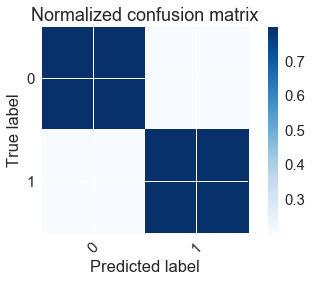

In [71]:
plot_confusion_matrix(y_test, pred)

Classification Report:

             precision    recall  f1-score   support

          0       0.95      0.98      0.96     34963
          1       0.51      0.34      0.41      2536

avg / total       0.92      0.93      0.93     37499


 Confusion matrix, without normalization: 

[[34129   834]
 [ 1677   859]]

 Normalized confusion matrix 

[[0.97614621 0.02385379]
 [0.6612776  0.3387224 ]]


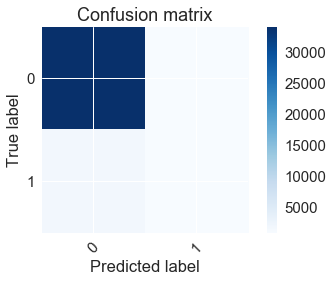

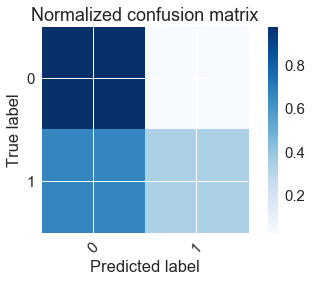

In [72]:
# Make predictions from the ADA model
predAda = makePredThresh(bestAdaModFitted, thr=0.4982)
plot_confusion_matrix(y_test, predAda)

In [ ]:
# https://github.com/IdoZehori/Credit_Score/blob/master/Credit%20score.ipynb